# LLM agent Hackathon 

## Alireza Ghafarollahi, MIT

# Create your first agent

In [13]:
import json
import os
import re

with open('config.json') as f:
    config = json.load(f)

OPENAI_API_KEY = config["api_key"]
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [14]:
from openai import OpenAI
import json
import os.path as osp
import subprocess

client = OpenAI(organization ='')

In [15]:
def extract_json_between_markers(llm_output):
    # Regular expression pattern to find JSON content between ```json and ```
    json_pattern = r"```json(.*?)```"
    matches = re.findall(json_pattern, llm_output, re.DOTALL)

    if not matches:
        # Fallback: Try to find any JSON-like content in the output
        json_pattern = r"\{.*?\}"
        matches = re.findall(json_pattern, llm_output, re.DOTALL)

    for json_string in matches:
        json_string = json_string.strip()
        try:
            parsed_json = json.loads(json_string)
            return parsed_json
        except json.JSONDecodeError:
            # Attempt to fix common JSON issues
            try:
                # Remove invalid control characters
                json_string_clean = re.sub(r"[\x00-\x1F\x7F]", "", json_string)
                parsed_json = json.loads(json_string_clean)
                return parsed_json
            except json.JSONDecodeError:
                continue  # Try next match

    return None  # No valid JSON found
    
def get_response_from_llm(
        system_message,
        prompt,
        model,
        reasoning_effort="medium",
        print_debug=False,
        msg_history=None,
        temperature=0.75,
        client=client):

    if msg_history is None:
        msg_history = []

    new_msg_history = msg_history + [{"role": "user", "content": prompt}]
    
    if model in ["gpt-4o", "gpt-4-turbo"]:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "developer", "content": system_message},
                *new_msg_history,
            ],
            temperature=temperature,
            max_completion_tokens=15000
        )
        print(token_usage(response))

    elif model in ["gpt-4.1"]:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "developer", "content": system_message},
                *new_msg_history,
            ],
            temperature=temperature,
            max_completion_tokens=20000
        )
        print(token_usage(response))
        
    elif model in ["o1", "o1-mini", "o3", "o3-mini"]:
        response = client.chat.completions.create(
            model=model,
            reasoning_effort=reasoning_effort,
            messages=[
                {"role": "developer", "content": system_message},
                *new_msg_history,
            ],
        )
        print(token_usage(response))
        
    content = response.choices[0].message.content
    new_msg_history = new_msg_history + [{"role": "assistant", "content": content}]

    if print_debug:
        print()
        print("*" * 20 + " LLM START " + "*" * 20)
        for j, msg in enumerate(new_msg_history):
            print(f'{j}, {msg["role"]}: {msg["content"]}')
        print(content)
        print("*" * 21 + " LLM END " + "*" * 21)
        print()

    return content, new_msg_history

def token_usage(response):
    dic = {"prompt tokens": response.usage.prompt_tokens,
          "completion tokens" : response.usage.completion_tokens,
          "total tokens": response.usage.total_tokens,
           "reasoning tokens": response.usage.completion_tokens_details.reasoning_tokens
          }
    return dic

In [17]:
system_message = '''You are a senior coder! 
You only return the python code in this format

```json
<JSON>
```

Where <JSON> is the python code.
'''

prompt = '''Write a python code that derives the mathematical expression for the roots of a third degree polynomial. 
Then give a sample function and compute its roots using the expressions. Finally, plot the function, showing the roots and annotaing the mathematical expression. 
'''
code, code_hosory = get_response_from_llm(system_message=system_message,
                     model='gpt-4o',
                     prompt=prompt)

{'prompt tokens': 95, 'completion tokens': 553, 'total tokens': 648, 'reasoning tokens': 0}


In [20]:
print(extract_json_between_markers(code)['code'])

import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, solve, Eq, simplify

# Define variables
a, b, c, d, x = symbols('a b c d x')

# Define the cubic polynomial
equation = Eq(a*x**3 + b*x**2 + c*x + d, 0)

# Derive the roots of the cubic polynomial
roots = solve(equation, x)

# Simplify roots expressions for better readability
roots_simplified = [simplify(root) for root in roots]

# Print the roots
print("Roots of the cubic equation:")
for idx, root in enumerate(roots_simplified, start=1):
    print(f"Root {idx}: {root}")

# Define a sample cubic function
def cubic_function(x_val):
    return 1 * x_val**3 - 6 * x_val**2 + 11 * x_val - 6

# Calculate roots for the sample cubic function
sample_roots = np.roots([1, -6, 11, -6])

# Plot the sample function and its roots
x_vals = np.linspace(0, 4, 400)
y_vals = cubic_function(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Cubic Function')
plt.scatter(sample_roots, cubic_function(sample_roots), 

Roots of the cubic equation:
Root 1: (-2**(2/3)*a**2*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(2/3) - 2*a*b*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(1/3) + 2*2**(1/3)*(3*a*c - b**2))/(6*a**2*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(1/3))
Root 2: (2**(2/3)*a**2*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(2/3)*(1 + sqrt(3)*I)**2 - 4*a*b*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(1/3)*(1 + sqrt(3)*I) - 8*2**(1/3)*(3*a*c - b**2))/(12*a**2*((a**3*sqrt((-4*(-3*a*c + b**2)**3 + (27*a**2*d - 9*a*b*c + 2*b**3)**2)/a**6) + 27*a**2*d - 9*a*b*c + 2*b**3)/a**3)**(1/3)*(1 + sqrt(3)*I))
Root 3: (2**(2/3)*a**2*((a**3*sqrt((-4*(-3

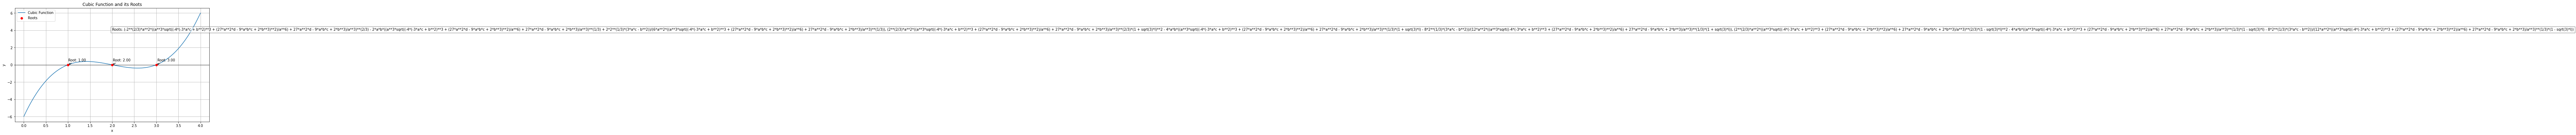

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, solve, Eq, simplify

# Define variables
a, b, c, d, x = symbols('a b c d x')

# Define the cubic polynomial
equation = Eq(a*x**3 + b*x**2 + c*x + d, 0)

# Derive the roots of the cubic polynomial
roots = solve(equation, x)

# Simplify roots expressions for better readability
roots_simplified = [simplify(root) for root in roots]

# Print the roots
print("Roots of the cubic equation:")
for idx, root in enumerate(roots_simplified, start=1):
    print(f"Root {idx}: {root}")

# Define a sample cubic function
def cubic_function(x_val):
    return 1 * x_val**3 - 6 * x_val**2 + 11 * x_val - 6

# Calculate roots for the sample cubic function
sample_roots = np.roots([1, -6, 11, -6])

# Plot the sample function and its roots
x_vals = np.linspace(0, 4, 400)
y_vals = cubic_function(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Cubic Function')
plt.scatter(sample_roots, cubic_function(sample_roots), color='red', zorder=5, label='Roots')

# Annotating the roots and equation
for root in sample_roots:
    plt.annotate(f'Root: {root:.2f}', xy=(root, 0), xytext=(root, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->'))

# Annotate the mathematical expression of the roots
expr_annotation = "Roots: " + ", ".join([str(root) for root in roots_simplified])
plt.annotate(expr_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Function and its Roots')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
system_message = '''You are a senior coder! 
You only return the python code in this format

```json
<JSON>
```

Where <JSON> is the python code.
'''

prompt = '''Write a python code that derives the mathematical expression for the roots of a third degree polynomial. 
Then give a sample function and compute its roots using the expressions. Finally, plot the function, showing the roots and annotaing the mathematical expression. 
'''
code, code_hosory = get_response_from_llm(system_message=system_message,
                     model='o3-mini',
                     prompt=prompt)

{'prompt tokens': 94, 'completion tokens': 3649, 'total tokens': 3743, 'reasoning tokens': 2240}


In [25]:
print(extract_json_between_markers(code)['code'])

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


def cubic_roots(a, b, c, d):
    """
    Computes the roots of the cubic polynomial:
        a*x^3 + b*x^2 + c*x + d = 0
    using the depressed cubic (Cardano's) method.
    Returns a list of three roots (which may be complex).
    """
    if a == 0:
        raise ValueError('Coefficient a must be non-zero for a cubic equation.')

    # Tschirnhaus substitution: x = y - b/(3a), to eliminate the quadratic term.
    shift = b / (3 * a)
    # Compute depressed cubic coefficients:
    # y^3 + p*y + q = 0  =>  p = c/a - b^2/(3a^2), q = 2b^3/(27a^3) - b*c/(3a^2) + d/a
    p = (3 * a * c - b**2) / (3 * a**2)
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)

    # The discriminant is defined as (q/2)^2 + (p/3)^3
    discriminant = (q / 2)**2 + (p / 3)**3
    
    # To handle square roots of negative numbers (if any), use numpy's scimath functions
    sqrt_disc = np.lib.scimath.sqrt(discriminant)
    
    #

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

Computed roots:
Root 1: 3.000000
Root 2: 1.000000
Root 3: 2.000000


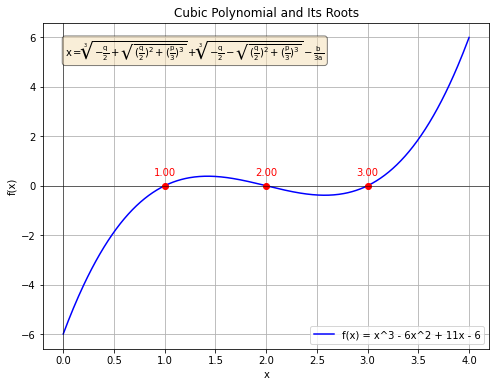

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


def cubic_roots(a, b, c, d):
    """
    Computes the roots of the cubic polynomial:
        a*x^3 + b*x^2 + c*x + d = 0
    using the depressed cubic (Cardano's) method.
    Returns a list of three roots (which may be complex).
    """
    if a == 0:
        raise ValueError('Coefficient a must be non-zero for a cubic equation.')

    # Tschirnhaus substitution: x = y - b/(3a), to eliminate the quadratic term.
    shift = b / (3 * a)
    # Compute depressed cubic coefficients:
    # y^3 + p*y + q = 0  =>  p = c/a - b^2/(3a^2), q = 2b^3/(27a^3) - b*c/(3a^2) + d/a
    p = (3 * a * c - b**2) / (3 * a**2)
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)

    # The discriminant is defined as (q/2)^2 + (p/3)^3
    discriminant = (q / 2)**2 + (p / 3)**3
    
    # To handle square roots of negative numbers (if any), use numpy's scimath functions
    sqrt_disc = np.lib.scimath.sqrt(discriminant)
    
    # Compute the two terms inside the cube roots
    term1 = -q / 2 + sqrt_disc
    term2 = -q / 2 - sqrt_disc
    
    # For correct handling of real and complex cube roots, we use logarithms
    # Note: This will choose a principal value, so using the cube roots of unity later recovers all roots.
    c1 = np.exp(np.log(term1) / 3.0)
    c2 = np.exp(np.log(term2) / 3.0)

    # The principal (Cardano's) solution
    y1 = c1 + c2
    x1 = y1 - shift

    # To get the other roots, use the cube roots of unity
    omega = np.exp(2j * np.pi / 3)
    y2 = c1 * omega + c2 * (omega**2)
    y3 = c1 * (omega**2) + c2 * omega
    x2 = y2 - shift
    x3 = y3 - shift

    return [x1, x2, x3]


# Sample cubic function: f(x) = x^3 - 6x^2 + 11x - 6, whose roots are 1, 2, and 3.
# Coefficients: a = 1, b = -6, c = 11, d = -6

a, b, c, d = 1, -6, 11, -6
roots = cubic_roots(a, b, c, d)
print('Computed roots:')
for idx, r in enumerate(roots, start=1):
    # Only display the real part if the imaginary component is negligible
    if abs(r.imag) < 1e-6:
        print(f'Root {idx}: {r.real:.6f}')
    else:
        print(f'Root {idx}: {r}')


def f(x):
    return a * x**3 + b * x**2 + c * x + d

# Generate a range of x values for plotting
x_vals = np.linspace(0, 4, 400)
y_vals = f(x_vals)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='f(x) = x^3 - 6x^2 + 11x - 6', color='blue')

# Plot and annotate the roots on the x-axis
for r in roots:
    # Only plot the real-valued roots (if imaginary part is negligible)
    if abs(r.imag) < 1e-6:
        plt.plot(r.real, 0, 'ro')
        plt.annotate(f'{r.real:.2f}', xy=(r.real, 0), xytext=(0, 10), textcoords='offset points', ha='center', color='red')

# Annotate the derived expression for the cubic roots.
# This is the formula:
# x = cube(-q/2 + sqrt((q/2)^2 + (p/3)^3)) + cube(-q/2 - sqrt((q/2)^2 + (p/3)^3)) - b/(3a)
# where p = c/a - b^2/(3a^2) and q = 2b^3/(27a^3) - b*c/(3a^2) + d/a
expr_text = (r'$x = \sqrt[3]{-\frac{q}{2} + \sqrt{(\frac{q}{2})^2 + (\frac{p}{3})^3}} + ' + 
             r'\sqrt[3]{-\frac{q}{2} - \sqrt{(\frac{q}{2})^2 + (\frac{p}{3})^3}} - \frac{b}{3a}$')
plt.text(0.05, 0.95, expr_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Cubic Polynomial and Its Roots')
plt.legend()
plt.grid(True)
plt.show()